In [ ]:
import numpy as np
import pandas as pd
from numpy import random
from numpy.random import randn
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import kf_book.book_plots as bp

df = pd.read_csv('sensorData.csv')
uwb_x = df.uwb_x
uwb_y = df.uwb_y
vel_linear_x = df['vel_linear_x'].fillna(0.0)

In [ ]:
len(vel_linear_x)

In [ ]:
type(uwb_x)

In [ ]:
uwbXArray= uwb_x.to_numpy()

In [ ]:
uwbXArray

In [ ]:
len(uwbXArray)

In [ ]:
len(uwb_x)

In [ ]:
# first nonzero value for uwb_x
ini_index = uwb_x.ne(0).idxmax()

In [ ]:
ini_index

In [ ]:
uwb_y[ini_index]

In [ ]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

In [ ]:
import kf_book.kf_internal as kf_internal
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '(={:.3f}, 2={:.3f})'.format(s[0], s[1])
# note: A large variance implies that confidence is very low, 
# so the filter estimates the position to be very close to the measurement
# specific to the robot
process_var = 0.028 ** 2
sensor_var = 0.077 ** 2
# sensor_var = 0.3 ** 2
# initial uwb_x: around 2 when real tag value received and written, otherwise 0.0
x = gaussian(uwb_x[ini_index], sensor_var) # robot's initial position(x-coordinate): first non-zero value of uwb_x

# if changed to 0.1 the kf precision will be lower
dt = 0.01

# measurements are uwb_x
# Kalman filter
print('    PREDICT\t\tMEASURE    UPDATE')
print('  x\t   var\t\tz\t  x\t  var')
# perform kf on measurement
for i, z in enumerate(uwb_x):
    velocity = vel_linear_x[i]
    process_model = gaussian(velocity*dt, process_var)
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
    
    kf_internal.print_gh(prior, x, z)
print('final estimate X-coordinate:\t{:10.3f} m'.format(x.mean))
print('tag final position:\t\t{:10.3f} m'.format(uwb_x.iloc[-1]))

In [ ]:
from kf_book import book_plots as book_plots
from ipywidgets import interact
from ipywidgets.widgets import IntSlider

# save output in these lists for plotting
xs, predictions = [], []

# process_model = gaussian(velocity, process_var) 

# perform Kalman filter
# x = gaussian(0., 20.**2)
for z in uwb_x:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    zs = uwb_x
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(-50, len(uwb_x) + 75)
    plt.ylim(min(uwb_x) - 0.5, max(uwb_x) + 0.5)
    plt.xlabel("Number of measurements")
    plt.ylabel("X-coordinate (m)")
#     loc=2
    plt.legend(loc='lower right');
#     plt.savefig('kalman_real_velocity.pdf', dpi=300)
# value denotes the initial value of the slider
interact(plot_filter, step=IntSlider(value=len(predictions)*3, min=1, max=len(predictions)*3));

Now we try KalmanFilter from filterpy:

In [ ]:
def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

In [ ]:
dt = 0.01
# initial X-coordinate and velocity
x = np.array([uwb_x[ini_index], vel_linear_x[0]]) 
kf = pos_vel_filter(x, P=np.diag([sensor_var, 0.1736111111]), R=sensor_var, Q=process_var, dt=dt)

In [ ]:
kf

In [ ]:
# try to get turning point of uwb_x
from scipy.signal import argrelextrema
argrelextrema(uwbXArray, np.less)

In [ ]:
import math

def compute_track(z_var, process_var, count=1, dt=0.01):
    "returns track 1D ndarrays"
    x = uwb_x[ini_index]
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for i in range(count - 1):
        vel = 0.5 if i < 1957 and vel_linear_x[i] else 0.0
        if vel:
            v = vel + (randn() * p_std)
        else:
            v = 0.0
        if i < 736 or 1132 <= i < 1530:
            x += v*dt        
        else:
            x -= v*dt
        xs.append(x)
        zs.append(x + randn() * z_std)        
    xs.append(xs[-1])
    return np.array(xs)

In [137]:
from kf_book.mkf_internal import plot_covariance

def plot_track(ps, actual, zs, cov, std_scale=1,
               plot_P=True, y_lim=None,
               xlabel='time', ylabel='position',
               title='Kalman Filter'):

    count = len(zs)
    zs = np.asarray(zs)

    cov = np.asarray(cov)
    std = std_scale * np.sqrt(cov[:, 0, 0])
    std_top = np.minimum(actual+std, [count + 10])
    std_btm = np.maximum(actual-std, [-50])

    std_top = actual + std
    std_btm = actual - std

    bp.plot_track(actual, c='k')
    bp.plot_measurements(range(1, count + 1), zs)
    bp.plot_filter(range(1, count + 1), ps)

    plt.plot(std_top, linestyle=':', color='k', lw=1, alpha=0.4)
    plt.plot(std_btm, linestyle=':', color='k', lw=1, alpha=0.4)
    plt.fill_between(range(len(std_top)), std_top, std_btm,
                     facecolor='yellow', alpha=0.2, interpolate=True)
    plt.legend(loc=4)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if y_lim is not None:
        plt.ylim(y_lim)
    else:
        plt.ylim((-50, count + 10))

    plt.xlim((-50, count + 50))
    plt.title(title)
    plt.show()
#     plt.savefig('kalman_with_track.pdf', dpi=300)

    if plot_P:
        ax = plt.subplot(121)
        ax.set_title(r"$\sigma^2_x$ (pos variance)")
        plot_covariance(cov, (0, 0))
        ax = plt.subplot(122)
        ax.set_title(r"$\sigma^2_\dot{x}$ (vel variance)")
        plot_covariance(cov, (1, 1))
        plt.show()        

In [145]:
def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the robot, zs are the 
    corresponding measurements. 
    """

    # if no data provided. 
    if zs is None:
        print(f"Measurements are necessary!")
        
    if not track:
        print(f"count = {count}")
        track = compute_track(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    print(f"cov = {cov}")
    if do_plot:
#       plot_track(xs[:, 0], track, zs, cov, dt=dt, **kwargs)  
        plot_track(xs[:, 0], track, zs, cov, y_lim=(min(uwb_x) - 0.5, max(uwb_x) + 0.5) , xlabel="Number of measurements", ylabel="X-coordinate (m)", **kwargs)
    return xs, cov

In [ ]:
x

count = 1984
cov = [[[0.00573966 0.00555659]
  [0.00555659 0.01132149]]

 [[0.00490411 0.00298531]
  [0.00298531 0.00340982]]

 [[0.00420662 0.00197167]
  [0.00197167 0.00193678]]

 ...

 [[0.0033859  0.00141202]
  [0.00141202 0.00148797]]

 [[0.0033859  0.00141202]
  [0.00141202 0.00148797]]

 [[0.0033859  0.00141202]
  [0.00141202 0.00148797]]]


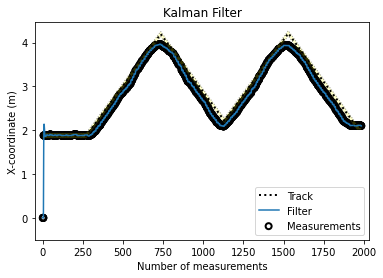

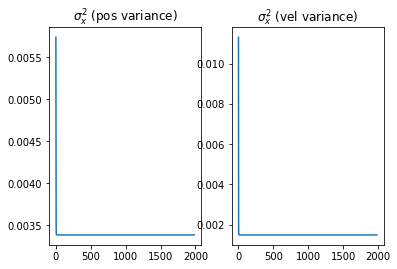

In [146]:
# # initial uncertainty: measurement variance for x-coordinate,
# and x-vel (small value means quite certain)
# maximum speed for the robot is 1.25 m/s, 3 * sigma = 1.25, sigma ** 2 can be calculated
P = np.diag([sensor_var, 0.1736111111])
# set do_plot=False if track data is not available
Ms, Ps = run(x0=x, count=len(uwb_x), R=sensor_var, Q=process_var, P=P, zs=uwb_x, do_plot=True)

In [ ]:
from kf_book.mkf_internal import plot_track_ellipses

def plot_covariances(count, R, Q=process_var, P=sensor_var, title=''):    
    zs = uwb_x
    f = pos_vel_filter(x=(uwb_x[ini_index], 0.), R=R, Q=Q, P=P)

    xs, cov = [], []
    for z in zs:
        f.predict()
        f.update(z)

        xs.append(f.x[0])
        cov.append(f.P)
    plot_track_ellipses(count, zs, xs, cov, title)

plt.figure(figsize=(15,9))
plt.subplot(121)
plot_covariances(R=sensor_var, Q=process_var, count=len(uwb_x), title='$R = (0.077 ** 2)\, m^2$')
plt.subplot(122)
plot_covariances(R=.1, Q=.02, count=len(uwb_x), title='$R = 0.5\, m^2$')

# Batch Processing

In [ ]:
count = len(uwb_x)
zs = uwb_x
# P = np.diag([500., 49.])
f = pos_vel_filter(x=(uwb_x[ini_index], 0.), R=sensor_var, Q=process_var, P=P)
xs, _, _, _ = f.batch_filter(zs)

book_plots.plot_measurements(range(1, count + 1), zs)
book_plots.plot_filter(range(1, count + 1), xs[:, 0])
plt.legend(loc='best');

In [ ]:
from filterpy.common import Saver
f = pos_vel_filter(x=(uwb_x[ini_index], 0.), R=sensor_var, Q=process_var, P=P)
s = Saver(f)
Xs, Covs, _, _ = f.batch_filter(zs, saver=s)
s.to_array()
plt.plot(s.y)
# plt.savefig('residual.pdf', dpi=300)

From above plot we can see noise centered around 0, which proves that the filter is well designed.

## Smoothing the Results

In [ ]:
Ms, Ps, _, _ = f.rts_smoother(Xs, Covs)

book_plots.plot_measurements(zs)
plt.plot(Xs[:, 0], ls='--', label='Kalman Position')
plt.plot(Ms[:, 0], label='RTS Position')
plt.legend(loc=4);
# plt.savefig('kalman_with_RTS.pdf', dpi=300)

In [ ]:
plt.plot(Xs[:, 1], ls='--', label='Kalman Velocity')
plt.plot(Ms[:, 1], label='RTS Velocity')
plt.legend(loc=4)
plt.gca().axhline(1, lw=1, c='k');

In [ ]:
dx = np.diff(Xs[:, 0], axis=0)

In [ ]:
len(range(1, len(dx) + 1))

In [ ]:
plt.scatter(range(0, len(dx) + 1), vel_linear_x, facecolor='none', 
            edgecolor='k', lw=2, label='Raw velocity')
# plt.plot(Xs[:, 1], ls='--', label='Filter')
# plt.plot(Ms[:, 1], label='RTS')
plt.xlabel("Number of Measurements")
plt.ylabel("X-velocity (m/s)")
plt.legend(loc='best');
# plt.savefig('raw_vel_x.pdf', dpi=300)

## Two Dimensional Kalman FIlter

In [ ]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

TwoDTracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 0.01
TwoDTracker.F = np.array([[1,dt, 0,0],
                        [0, 1, 0, 0],
                        [0, 0, 1, dt],
                        [0, 0, 0, 1]])
q = Q_discrete_white_noise(dim=2, dt=dt, var=process_var)
TwoDTracker.Q = block_diag(q,q)

In [ ]:
TwoDTracker.Q

In [ ]:
TwoDTracker.B

In [ ]:
# measurements for (x, y)
TwoDTracker.H = np.array([[1., 0., 0., 0], [0., 0., 1., 0.]])

In [ ]:
sensor_var_lateral = 0.125 ** 2
TwoDTracker.R = np.array([[sensor_var, 0], [0, sensor_var_lateral]])

In [ ]:
TwoDTracker.R

In [ ]:
# initial pos get from UWB tag, initial x-velocity get from vel_linear_x, y-velocity is always 0.0 m/s
TwoDTracker.x = np.array([[uwb_x[ini_index], vel_linear_x[0], uwb_y[ini_index], 0]]).T
# since we are quite sure about the initial pose and velocity, so set the covariance matrix P to a small value.
TwoDTracker.P = np.eye(4) * 0.5

## Implement the Filter

In [154]:
from filterpy.stats import plot_covariance_ellipse
from kf_book.book_plots import plot_filter

process_var_lateral = 0.019 ** 2

def track():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 0.01
    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    tracker.u = 0.
    tracker.H = np.array([[1., 0., 0., 0], [0., 0., 1., 0.]])

    tracker.R = np.array([[sensor_var, 0], [0, sensor_var_lateral]])
    q_forward = Q_discrete_white_noise(dim=2, dt=dt, var=process_var)
    q_lateral = Q_discrete_white_noise(dim=2, dt=dt, var=process_var_lateral)
    tracker.Q = block_diag(q_forward, q_lateral)
    tracker.x = np.array([[uwb_x[ini_index], vel_linear_x[0], uwb_y[ini_index], 0]]).T
    tracker.P = np.eye(4) * 0.5
    return tracker

# robot single movement
N = 735
zs = np.array([[uwb_x[i], uwb_y[i]] for i in range(N)])

In [150]:
zs

array([[0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       ...,
       [3.96, 2.19],
       [3.96, 2.19],
       [3.96, 2.19]])

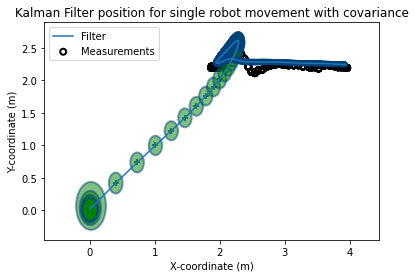

In [156]:
from kf_book.book_plots import plot_measurements

# run filter
robot_tracker = track()
# batch_filter is quite slow
mu, cov, _, _ = robot_tracker.batch_filter(zs)

for x, P in zip(mu, cov):
#     covariance or x and y
    cov = np.array([[P[0, 0], P[2, 0]],
                   [P[0, 2], P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
#     print(f"mean = {mean}, \n cov = {cov}")
#     plot_covariance(cov, mean)
    plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)

# plot result
plot_filter(mu[:, 0], mu[:, 2])
plot_measurements(zs[:, 0], zs[:, 1])
plt.title('Kalman Filter position for single robot movement with covariance')
plt.xlabel("X-coordinate (m)")
plt.ylabel("Y-coordinate (m)")
plt.legend(loc='best')
# plt.show()
# plt.savefig('single_move.pdf', dpi=300)

## circle movement

In [163]:
df1 = pd.read_csv('oval.csv')
uwb_x1 = df1.uwb_x
uwb_y1 = df1.uwb_y
vel_linear_x1 = df1['vel_linear_x'].fillna(0.0)
# first nonzero value for uwb_x
ini_index1 = uwb_x1.ne(0).idxmax()

Check UWB tag trace:

(<matplotlib.collections.PathCollection at 0x7fc11aa90410>,)

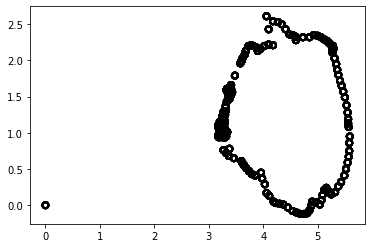

In [165]:
plot_measurements(uwb_x1, uwb_y1)

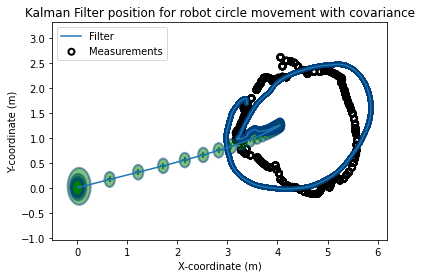

In [167]:
def track():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 0.01
    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    tracker.u = 0.
    tracker.H = np.array([[1., 0., 0., 0], [0., 0., 1., 0.]])

    tracker.R = np.array([[sensor_var, 0], [0, sensor_var_lateral]])
    q_forward = Q_discrete_white_noise(dim=2, dt=dt, var=process_var)
    q_lateral = Q_discrete_white_noise(dim=2, dt=dt, var=process_var_lateral)
    tracker.Q = block_diag(q_forward, q_lateral)
    tracker.x = np.array([[uwb_x1[ini_index1], vel_linear_x1[0], uwb_y1[ini_index1], 0]]).T
    tracker.P = np.eye(4) * 0.5
    return tracker
# robot circle movement
N = len(uwb_x1)
zs1 = np.array([[uwb_x1[i], uwb_y1[i]] for i in range(N)])

# run filter
robot_tracker = track()
# batch_filter is quite slow
mu, cov, _, _ = robot_tracker.batch_filter(zs1)

for x, P in zip(mu, cov):
#     covariance or x and y
    cov = np.array([[P[0, 0], P[2, 0]],
                   [P[0, 2], P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
#     print(f"mean = {mean}, \n cov = {cov}")
#     plot_covariance(cov, mean)
    plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)

# plot result
plot_filter(mu[:, 0], mu[:, 2])
plot_measurements(zs1[:, 0], zs1[:, 1])
plt.title('Kalman Filter position for robot oval movement with covariance')
plt.xlabel("X-coordinate (m)")
plt.ylabel("Y-coordinate (m)")
plt.legend(loc='best')
# plt.show()
# plt.savefig('oval.pdf', dpi=300)

## Trapezoid movement

In [168]:
df2 = pd.read_csv('pentagon.csv')
uwb_x2 = df2.uwb_x
uwb_y2 = df2.uwb_y
vel_linear_x2 = df2['vel_linear_x'].fillna(0.0)
# first nonzero value for uwb_x
ini_index2 = uwb_x2.ne(0).idxmax()

(<matplotlib.collections.PathCollection at 0x7fc11b6a1450>,)

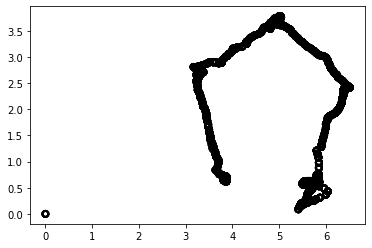

In [170]:
plot_measurementsurements(uwb_x2, uwb_y2)

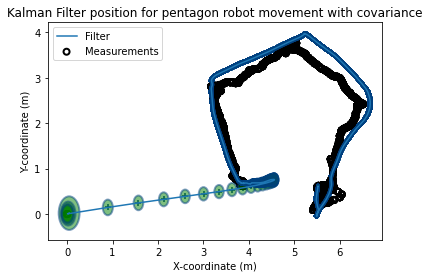

In [175]:
def track():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 0.01
    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    tracker.u = 0.
    tracker.H = np.array([[1., 0., 0., 0], [0., 0., 1., 0.]])

    tracker.R = np.array([[sensor_var, 0], [0, sensor_var_lateral]])
    q_forward = Q_discrete_white_noise(dim=2, dt=dt, var=process_var)
    q_lateral = Q_discrete_white_noise(dim=2, dt=dt, var=process_var_lateral)
    tracker.Q = block_diag(q_forward, q_lateral)
    tracker.x = np.array([[uwb_x2[ini_index2], vel_linear_x2[0], uwb_y2[ini_index2], 0]]).T
    tracker.P = np.eye(4) * 0.5
    return tracker
# robot trapezoid movement
N = len(uwb_x2)
zs2 = np.array([[uwb_x2[i], uwb_y2[i]] for i in range(N)])

# run filter
robot_tracker = track()
# batch_filter is quite slow
mu, cov, _, _ = robot_tracker.batch_filter(zs2)

for x, P in zip(mu, cov):
#     covariance or x and y
    cov = np.array([[P[0, 0], P[2, 0]],
                   [P[0, 2], P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
#     print(f"mean = {mean}, \n cov = {cov}")
#     plot_covariance(cov, mean)
    plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)

# plot result
plot_filter(mu[:, 0], mu[:, 2])
plot_measurements(zs2[:, 0], zs2[:, 1])
plt.title('Kalman Filter position for pentagon robot movement with covariance')
plt.xlabel("X-coordinate (m)")
plt.ylabel("Y-coordinate (m)")
plt.legend(loc='best')
# plt.show()
# plt.savefig('pentagon.pdf', dpi=300)